### 1. Read in the enriched PartB data for year 2013 & 2014

In [5]:
import pandas as pd
import numpy as np
import os 
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
parent = os.path.dirname(os.path.dirname(os.getcwd()))

# read in the claim data with year from 2013 to 2014
df = pd.read_csv(parent + '/CMS_datasets/data/year2013_2014_combined_with_labels.csv')

# fill nulls with 0
df.fillna(0, inplace=True)
print(df.shape)
sum(df[df.Fraud_Indicator ==1].groupby('Rndrng_NPI').size()==2)

# assign categorical features to the numeric code for each category
df['Rndrng_Prvdr_Type'] = df['Rndrng_Prvdr_Type'].astype('category').cat.codes
df['Rndrng_Prvdr_Gndr'] = df['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [6]:
import random
import cloudpickle
# split out a holdout set for final evaluation, using train_X and train_y for train set evaluation and model tuning
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

char_feat = ['Rndrng_Prvdr_Type', 'Rndrng_Prvdr_Gndr', 'Rndrng_Prvdr_Mdcr_Prtcptg_Ind']
num_feat = list(set(train_X.columns) - set(char_feat))

### 3. build up a pipeline including evaluation

In [22]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# define pipeline
def lgr_roc_aic_eval(undersample_rate= None):
    lgr = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1, verbose=1)

    cleaner = ColumnTransformer(
        transformers=[            
            ('scaling', StandardScaler(), num_feat),
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), char_feat)], remainder='drop')
        
    if undersample_rate == None:
        steps = [("cleaner", cleaner),
                 ('lgr', lgr)]    
        
    elif undersample_rate != None:
        under = RandomUnderSampler(sampling_strategy=undersample_rate, random_state=42)
        steps = [('under', under), 
                 ("cleaner", cleaner),
                 ('lgr', lgr)]
        
    pipeline = Pipeline(steps=steps)


    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    
    param_grid = {'lgr__penalty' : ['l1', 'l2'],
                  'lgr__C' : np.logspace(-3, 4, 10),
                  'lgr__solver' : ['liblinear'],
                  'lgr__max_iter': [100, 200, 500]},


    
    grid_pipe = GridSearchCV(estimator = pipeline, 
                             param_grid = param_grid, 
                             scoring= 'roc_auc', 
                             n_jobs =-1,
                             cv = skf,
                             verbose = 1)
    
    grid_result = grid_pipe.fit(train_X, train_y)
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    

    scores = cross_val_score(grid_result.best_estimator_, train_X, train_y, scoring = 'roc_auc', cv=skf, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores), 
          'SD ROC AUC: %.4f' % np.std(scores))
    
    val_auc = roc_auc_score(test_y, grid_result.best_estimator_.predict_proba(test_X)[:, 1])
    print('Test set ROC AUC  %.3f' % val_auc)
    return round(np.mean(scores), 4), round(np.std(scores), 5), round(val_auc, 4), grid_result.best_estimator_

def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)

    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.ylabel('Actual',fontsize=15)
    plt.xlabel('Prediction',fontsize=15)
    plt.title('Confusion Matrix', fontsize=17)
    return plt.show()

### 4. Output the roc_auc score - (Train set mean score, Train set score standard deviation, Test score)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LibLinear]Best Score:  0.8405609169381612
Best Params:  {'lgr__C': 1.291549665014884, 'lgr__max_iter': 200, 'lgr__penalty': 'l1', 'lgr__solver': 'liblinear'}
Mean ROC AUC: 0.841 SD ROC AUC: 0.0074
Test set ROC AUC  0.813
(0.8406, 0.00742, 0.8126)


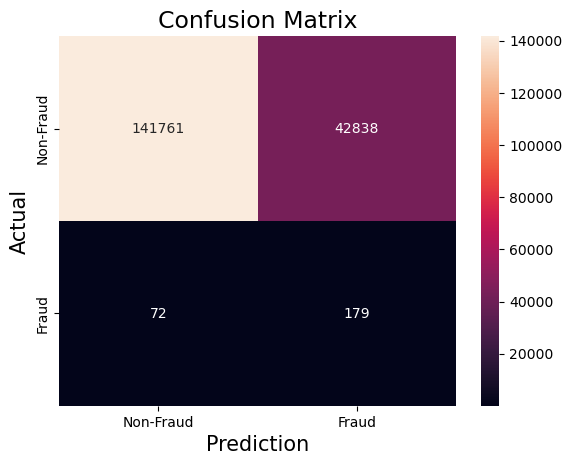

In [23]:
# undersample the majority/minority labels to ratio 10:1
lgr_1 = lgr_roc_aic_eval(0.1)
print(lgr_1[:3])
lgr_pipe1 = lgr_1[3]
plot_confusion_matrix(lgr_pipe1, test_X, test_y)

cloudpickle.dump(lgr_pipe1, open('lgr_pipe1.cloudpickle','wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LibLinear]Best Score:  0.8401041623957012
Best Params:  {'lgr__C': 7.742636826811269, 'lgr__max_iter': 200, 'lgr__penalty': 'l1', 'lgr__solver': 'liblinear'}
Mean ROC AUC: 0.840 SD ROC AUC: 0.0084
Test set ROC AUC  0.811
(0.8401, 0.00841, 0.8114)


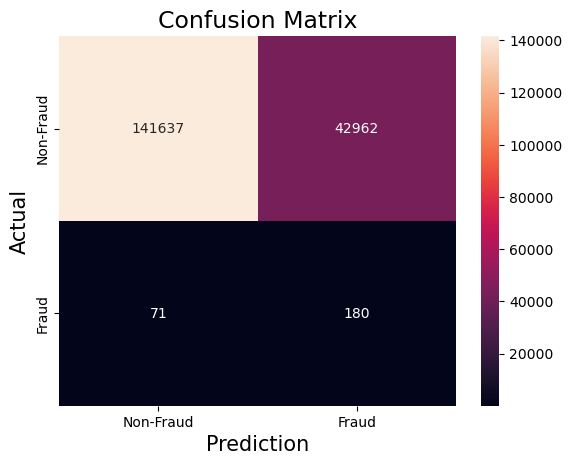

In [24]:
# undersample the majority/minority labels to ratio 4:1
lgr_2 = lgr_roc_aic_eval(0.25)
print(lgr_2[:3])
lgr_pipe2 = lgr_2[3]
plot_confusion_matrix(lgr_pipe2, test_X, test_y)

cloudpickle.dump(lgr_pipe2, open('lgr_pipe2.cloudpickle','wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LibLinear]Best Score:  0.8383888822235426
Best Params:  {'lgr__C': 10000.0, 'lgr__max_iter': 200, 'lgr__penalty': 'l2', 'lgr__solver': 'liblinear'}
Mean ROC AUC: 0.838 SD ROC AUC: 0.0081
Test set ROC AUC  0.810
(0.8384, 0.0081, 0.81)


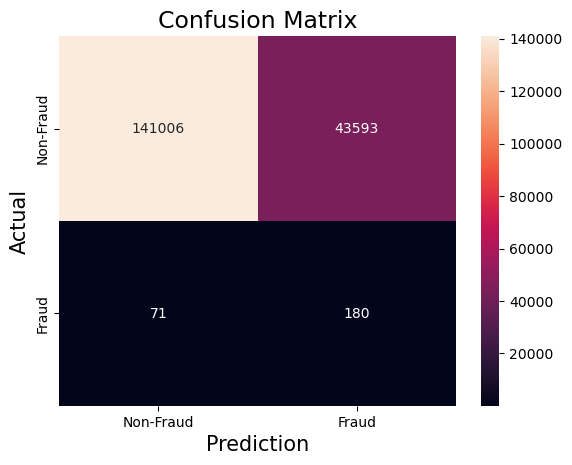

In [25]:
# undersample the majority/minority labels to ratio 2:1
lgr_3 = lgr_roc_aic_eval(0.5)
print(lgr_3[:3])
lgr_pipe3 = lgr_3[3]
plot_confusion_matrix(lgr_pipe3, test_X, test_y)

cloudpickle.dump(lgr_pipe3, open('lgr_pipe3.cloudpickle','wb'))

In [19]:
# undersample the majority/minority labels to ratio 1:1
lgr_4 = lgr_roc_aic_eval(1)
print(lgr_4[:3])
lgr_pipe4 = lgr_4[3]
plot_confusion_matrix(lgr_pipe4, test_X, test_y)

cloudpickle.dump(lgr_pipe4, open('lgr_pipe4.cloudpickle','wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LibLinear]Best Score:  0.8336462232972568
Best Params:  {'lgr__C': 2.782559402207126, 'lgr__max_iter': 100, 'lgr__penalty': 'l2', 'lgr__solver': 'liblinear'}
Mean ROC AUC: 0.834 SD ROC AUC: 0.0069
Test set ROC AUC  0.810
(0.8336, 0.00686, 0.8099)


NameError: name 'lgr_pipe4' is not defined

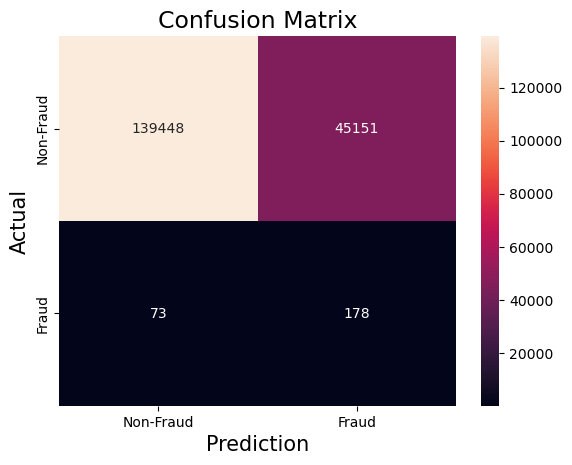

In [21]:
import cloudpickle
lgr_pipe4 = lgr_4[3]
plot_confusion_matrix(lgr_pipe4, test_X, test_y)

cloudpickle.dump(lgr_pipe4, open('lgr_pipe4.cloudpickle','wb'))